In [1]:
# Setup
!pip install --quiet --upgrade pip
!pip install --quiet tensorflow
!pip install --quiet tensorflow_io

In [7]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import tensorflow as tf
import matplotlib.pyplot as plt
from serving.hist_training import load_dataset_from_gcp, load_model_from_gcs
from serving.constants import BUCKET
from google.cloud import storage
import google.auth
import tensorflow_io as tfio
import numpy as np

client = storage.Client()
bucket = client.get_bucket(BUCKET)
num_bins = 32
dataset_suffix = r".tfrecords"
model_suffix =r".tf"

In [8]:
%load_ext tensorboard
%tensorboard --logdir=gs://vgnn/tensorboard-artifacts/logs/fit/ --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
!kill 131520

In [35]:
file_name = f"{num_bins}_buckets_training_test" # "hist_dataset_medium" # 
file_name += dataset_suffix

model_name ="kind-sopapillas.tf"

In [36]:
model = load_model_from_gcs(model_name)
print(f"Model loaded: {model_name}")

test_dataset = load_dataset_from_gcp(file_name=file_name)
print(f"Dataset loaded: {file_name}")

predictions = model.predict(test_dataset)

Model loaded: glum-chocolate-20241025-221148.tf
Dataset loaded: 256_buckets_training_test.tfrecords
3824/3824 [==============================] - 22s 6ms/step


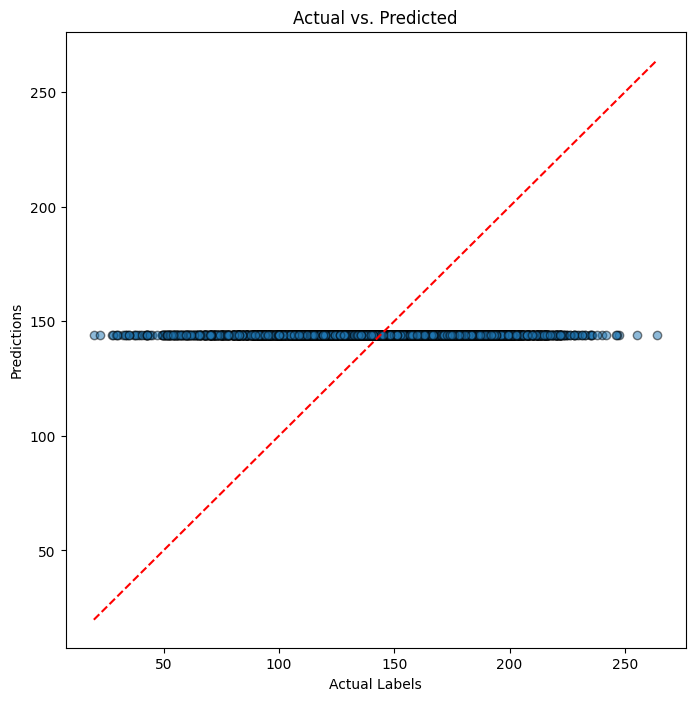

In [37]:
actual_labels = np.concatenate([response.numpy() for _, response in test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [39]:
len(predictions.reshape(-1))

3823

In [38]:
len(actual_labels)

3823

In [9]:
print(np.mean(actual_labels),
      np.std(actual_labels),
      sep="\n")

142.43382
41.05487


In [10]:
print(np.mean(predictions.reshape(-1)),
      np.std(predictions.reshape(-1)),
      sep="\n")

135.15503
0.0


In [40]:
# Assuming your test_dataset is properly defined and yields batches of (input, target)
for input_data, _ in test_dataset.take(10):  # Take the first batch
    with tf.GradientTape() as tape:
        tape.watch(input_data)  # Watch the input data
        predictions = model(input_data)  # Forward pass to get predictions

    # Compute gradients of the output with respect to the inputs
    gradients = tape.gradient(predictions, input_data)

    # Print or analyze the predictions and gradients
    print("Predictions:", predictions.numpy())
    print("Gradients:", gradients.numpy())

Predictions: [[144.0494]]
Gradients: [[ 1.7702041e-16  7.1305500e-18 -1.2949111e-17 ...  1.4303878e-17
   9.7465674e-18  5.0852781e-18]
 [ 2.4206034e-18  9.8376849e-20 -1.7623852e-19 ...  1.9566773e-19
   1.3241789e-19  7.0335956e-20]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Predictions: [[144.0494]]
Gradients: [[ 1.76904313e-16  7.12587312e-18 -1.29406195e-17 ...  1.42944966e-17
   9.74017496e-18  5.08194291e-18]
 [ 2.42047316e-18  9.83716013e-20 -1.76229020e-19 ...  1.95657218e-19
   1.32410769e-19  7.03322207e-20]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Predictions: [[144.0494]]
Gradients: [[ 1.7611047e-16  7.0938968e-18 -1.2882547e-17 ...  1.4230350e-17
   9.6964659e-18  5.0591371e-18]
 [ 2.4197194e-18  9.8341241e-20 -1.7617384e-19 ...  1.9559630e-19
   1.3236924e-19  7.0310565e-20]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.000000

In [43]:
labels = []
for features, label in test_dataset.take(100):
    labels.append(label.numpy()[0])

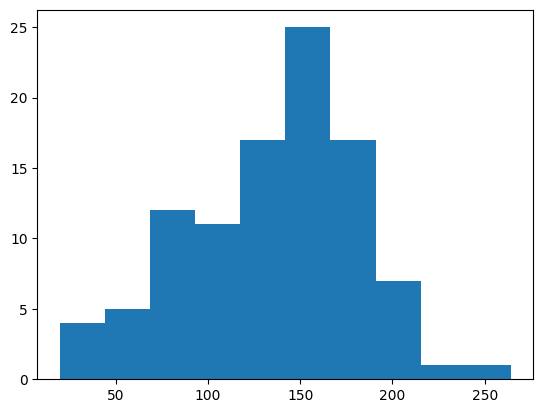

In [45]:
plt.hist(labels)
plt.show()